# MACD Calculator

## Weekly MACD Trading Strategy

[*********************100%%**********************]  1 of 1 completed


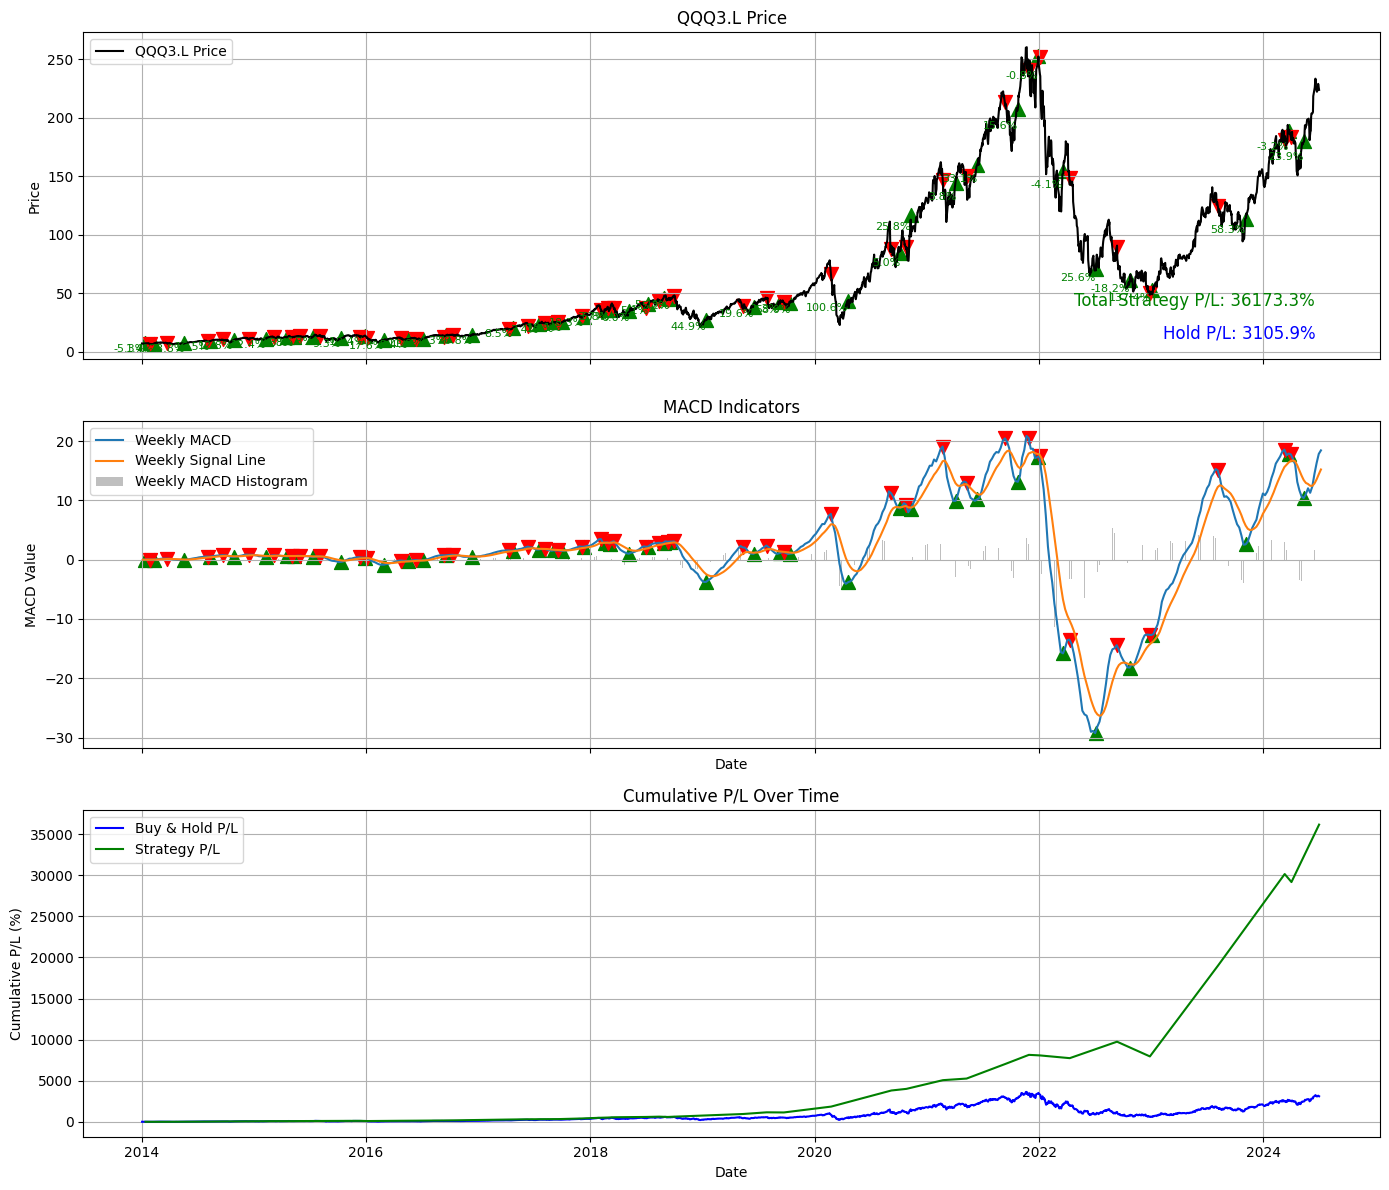

     Buy Date  Sell Date   Buy Price  Sell Price     P/L (%)
0  2014-01-13 2014-01-27    6.988000    6.645120   -5.286308
1  2014-02-10 2014-03-24    6.933500    7.058240    1.392710
2  2014-05-19 2014-08-04    7.078980    8.800770   23.826272
3  2014-08-11 2014-09-22    8.931410   10.445820   16.489112
4  2014-10-27 2014-12-15    9.688310   10.975040   12.829051
5  2015-02-09 2015-03-09   10.899350   12.305070   12.446593
6  2015-04-20 2015-05-05   12.338370   12.428290    0.326673
7  2015-05-11 2015-06-01   12.579670   13.230600    4.754605
8  2015-07-13 2015-08-03   12.762230   13.615110    6.256969
9  2015-10-12 2015-12-14   11.308080   12.413150    9.334181
10 2015-12-29 2016-01-04   13.397120   11.784320  -12.389556
11 2016-02-29 2016-04-25    9.536930   11.262660   17.623797
12 2016-05-16 2016-06-13   10.586750   11.202110    5.390146
13 2016-07-04 2016-09-12   11.044680   12.371070   11.562171
14 2016-09-19 2016-10-10   13.987500   14.653570    4.343683
15 2016-12-12 2017-04-10

In [889]:
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from datetime import datetime, timedelta
import numpy as np

def calculate_macd(df, short_window=12, long_window=26, signal_window=9):
    """
    Calculate the MACD and Signal Line indicators
    """
    df['EMA_short'] = df['Close'].ewm(span=short_window, adjust=False).mean()
    df['EMA_long'] = df['Close'].ewm(span=long_window, adjust=False).mean()
    df['MACD'] = df['EMA_short'] - df['EMA_long']
    df['Signal_Line'] = df['MACD'].ewm(span=signal_window, adjust=False).mean()
    return df

def calculate_gradients(df):
    """
    Calculate the gradient (slope) of the MACD and Signal Line
    """
    df['MACD_Gradient'] = np.gradient(df['MACD'])
    return df

def find_turning_points(df):
    """
    Find turning points in the MACD gradient for buy and sell signals
    """
    turning_points_buy = []
    turning_points_sell = []
    
    for i in range(1, len(df)-1):
        # Buy condition: MACD gradient turns positive from negative
        if df['MACD_Gradient'].iloc[i-1] < 0 and df['MACD_Gradient'].iloc[i] >= 0:
            turning_points_buy.append((df.index[i], df['Close'].iloc[i], df['MACD'].iloc[i]))
        
        # Sell condition: MACD gradient turns negative from positive
        if df['MACD_Gradient'].iloc[i-1] > 0 and df['MACD_Gradient'].iloc[i] <= 0:
            turning_points_sell.append((df.index[i], df['Close'].iloc[i], df['MACD'].iloc[i]))
    
    return turning_points_buy, turning_points_sell

def find_next_trading_day(date, df):
    """
    Find the next trading day after the given date
    """
    next_day = date + timedelta(days=1)
    while next_day not in df.index:
        next_day += timedelta(days=1)
    return next_day

def filter_signals(buy_signals, sell_signals, df):
    """
    Filter buy and sell signals to ensure proper sequence and trade on the next trading day
    """
    filtered_buy_signals = []
    filtered_sell_signals = []
    
    last_sell_date = None
    
    for buy_signal in buy_signals:
        next_buy_date = find_next_trading_day(buy_signal[0], df)
        if last_sell_date is None or next_buy_date > last_sell_date:
            filtered_buy_signals.append((next_buy_date, df.loc[next_buy_date, 'Open'], buy_signal[2]))
            corresponding_sell_signal = next((sell_signal for sell_signal in sell_signals if find_next_trading_day(sell_signal[0], df) > next_buy_date), None)
            if corresponding_sell_signal:
                next_sell_date = find_next_trading_day(corresponding_sell_signal[0], df)
                filtered_sell_signals.append((next_sell_date, df.loc[next_sell_date, 'Open'], corresponding_sell_signal[2]))
                last_sell_date = next_sell_date
    
    return filtered_buy_signals, filtered_sell_signals

def calculate_profit_loss(buy_signals, sell_signals, df_price, transaction_fee=0.002):
    """
    Calculate the profit/loss based on buy and sell signals with transaction fees
    """
    profit_loss = []
    cumulative_pl = []
    capital = 100  # Starting capital (arbitrary value for percentage calculation)
    
    trade_dates = []

    for i in range(len(buy_signals)):
        buy_price = buy_signals[i][1] * (1 + transaction_fee)  # Apply transaction fee on buy
        if i < len(sell_signals):
            sell_price = sell_signals[i][1] * (1 - transaction_fee)  # Apply transaction fee on sell
            sell_date = sell_signals[i][0]
        else:
            sell_price = df_price['Close'].iloc[-1] * (1 - transaction_fee)  # Apply transaction fee on final price
            sell_date = df_price.index[-1]
        pl = (sell_price - buy_price) / buy_price * 100
        capital *= (1 + pl / 100)
        profit_loss.append(pl)
        cumulative_pl.append(capital - 100)
        trade_dates.append((buy_signals[i][0], sell_date))
    
    # Calculate hold profit/loss
    start_price = df_price['Close'].iloc[0]
    end_price = df_price['Close'].iloc[-1]
    hold_pl = (end_price - start_price) / start_price * 100
    
    return profit_loss, hold_pl, cumulative_pl, trade_dates

def plot_price_macd(df_price, df_weekly, buy_signals, sell_signals, profit_loss, hold_pl, cumulative_pl, trade_dates):
    """
    Plot the stock price along with weekly MACD indicators and cumulative P/L
    """
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(14, 12), sharex=True)
    
    ax1.plot(df_price.index, df_price['Close'], label=f'{ticker} Price', color='black')
    ax1.set_title(f'{ticker} Price')
    ax1.set_ylabel('Price')
    ax1.legend(loc='upper left')
    ax1.grid(True)
    
    # Mark the buy signals on the stock price graph
    for date, price, macd_value in buy_signals:
        ax1.scatter(date, price, color='green', marker='^', s=100, label='Buy Signal')
    
    # Mark the sell signals on the stock price graph
    for date, price, macd_value in sell_signals:
        ax1.scatter(date, price, color='red', marker='v', s=100, label='Sell Signal')
    
    # Calculate and display profit/loss if bought at the first buy signal and sold at subsequent sell signals
    for i, pl in enumerate(profit_loss):
        ax1.text(buy_signals[i][0], buy_signals[i][1] * 0.95, f'{pl:.1f}%', fontsize=8, color='green', ha='right', va='top')
    
    # Calculate and display profit/loss if bought at start date and held until end date
    ax1.text(0.95, 0.05, f'Hold P/L: {hold_pl:.1f}%', transform=ax1.transAxes, fontsize=12, color='blue', ha='right', va='bottom')

    # Display total P/L from buy/sell strategy
    ax1.text(0.95, 0.15, f'Total Strategy P/L: {cumulative_pl[-1]:.1f}%', transform=ax1.transAxes, fontsize=12, color='green', ha='right', va='bottom')

    ax2.plot(df_weekly.index, df_weekly['MACD'], label='Weekly MACD', color='tab:blue', linewidth=1.5)
    ax2.plot(df_weekly.index, df_weekly['Signal_Line'], label='Weekly Signal Line', color='tab:orange', linestyle='-', linewidth=1.5)
    ax2.bar(df_weekly.index, df_weekly['MACD'] - df_weekly['Signal_Line'], label='Weekly MACD Histogram', color='grey', alpha=0.5)
    
    # Mark the buy signals on the MACD graph
    for date, price, macd_value in buy_signals:
        ax2.scatter(date, macd_value, color='green', marker='^', s=100)
    
    # Mark the sell signals on the MACD graph
    for date, price, macd_value in sell_signals:
        ax2.scatter(date, macd_value, color='red', marker='v', s=100)
    
    ax2.set_title('MACD Indicators')
    ax2.set_xlabel('Date')
    ax2.set_ylabel('MACD Value')
    ax2.legend(loc='upper left')
    ax2.grid(True)
    
    # Plot cumulative P/L over time
    ax3.plot(df_price.index, (df_price['Close'] / df_price['Close'].iloc[0] - 1) * 100, label='Buy & Hold P/L', color='blue')
    strategy_dates = [trade[1] for trade in trade_dates]
    strategy_dates.insert(0, trade_dates[0][0])
    cumulative_pl.insert(0, 0)
    ax3.plot(strategy_dates, cumulative_pl, label='Strategy P/L', color='green')
    ax3.set_title('Cumulative P/L Over Time')
    ax3.set_xlabel('Date')
    ax3.set_ylabel('Cumulative P/L (%)')
    ax3.legend(loc='upper left')
    ax3.grid(True)
    
    plt.tight_layout()
    plt.show()

    # Create a table of trades and their profit/loss
    trade_data = {
        'Buy Date': [trade[0] for trade in trade_dates],
        'Sell Date': [trade[1] for trade in trade_dates],
        'Buy Price': [buy_signals[i][1] for i in range(len(buy_signals))],
        'Sell Price': [sell_signals[i][1] if i < len(sell_signals) else df_price['Close'].iloc[-1] for i in range(len(buy_signals))],
        'P/L (%)': profit_loss
    }
    trade_df = pd.DataFrame(trade_data)
    print(trade_df)

def simulate_additional_investments(df_price, buy_signals, sell_signals, initial_capital=6000, annual_contribution=20000):
    """
    Simulate adding an extra £20,000 each tax year by investing it monthly
    """
    total_investment = initial_capital
    capital = initial_capital
    monthly_contribution = annual_contribution / 12
    monthly_dates = pd.date_range(start=df_price.index[0], end=df_price.index[-1], freq='M')
    
    for date in monthly_dates:
        total_investment += monthly_contribution
        capital += monthly_contribution
    
    for i in range(len(buy_signals)):
        buy_price = buy_signals[i][1] * (1 + 0.002)  # Apply transaction fee on buy
        if i < len(sell_signals):
            sell_price = sell_signals[i][1] * (1 - 0.002)  # Apply transaction fee on sell
        else:
            sell_price = df_price['Close'].iloc[-1] * (1 - 0.002)  # Apply transaction fee on final price
        pl = (sell_price - buy_price) / buy_price
        capital *= (1 + pl)
    
    final_value = capital
    return total_investment, final_value

# Main script
if __name__ == "__main__":
    ticker = 'QQQ3.L'
    start_date = '2014-01-01'
    end_date = datetime.today().strftime('%Y-%m-%d')
    df = yf.download(ticker, start=start_date, end=end_date)
    
    df_weekly = df.resample('W').last()
    
    df_weekly = calculate_macd(df_weekly)
    df_weekly = calculate_gradients(df_weekly)
    
    buy_signals, sell_signals = find_turning_points(df_weekly)
    
    filtered_buy_signals, filtered_sell_signals = filter_signals(buy_signals, sell_signals, df)
    
    profit_loss, hold_pl, cumulative_pl, trade_dates = calculate_profit_loss(filtered_buy_signals, filtered_sell_signals, df)
    
    plot_price_macd(df, df_weekly, filtered_buy_signals, filtered_sell_signals, profit_loss, hold_pl, cumulative_pl, trade_dates)
    
    # Simulate additional investments
    total_investment, final_value = simulate_additional_investments(df, filtered_buy_signals, filtered_sell_signals)
    
    print(f"Total Investment: £{total_investment:,.2f}")
    print(f"Final Value: £{final_value:,.2f}")
    print(f"Net Profit: £{final_value - total_investment:,.2f}")